In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import sys
import os
sys.path.append(os.path.join(os.environ['NHL_DATA_DIR'], '..'))

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb


import src.visualization.visualize as VizManager
import src.data.NHLDataManager as DataManager
import src.features.build_features as FeaturesManager



RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [4]:
# Get the dataset
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
features_data_df = FeaturesManager.build_features(seasons_year, season_type, with_player_stats=True, with_strength_stats=True)
features_data_df.shape

(305860, 37)

In [5]:
features_data_df = features_data_df.fillna(features_data_df.median())

col3 = 'Shot Type'
features_data_df[col3] = features_data_df[col3].fillna(features_data_df[col3].mode().iloc[0])

features_data_df.info()

/tmp/ipykernel_24181/1816136785.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  features_data_df = features_data_df.fillna(features_data_df.median())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305860 entries, 0 to 305859
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Game ID                         305860 non-null  object 
 1   Event Index                     305860 non-null  int64  
 2   Period                          305860 non-null  int64  
 3   Team                            305860 non-null  object 
 4   Type                            305860 non-null  object 
 5   Shot Type                       305860 non-null  object 
 6   Shooter                         305860 non-null  object 
 7   Shooter ID                      305860 non-null  float64
 8   Goalie                          305860 non-null  object 
 9   Goalie ID                       305860 non-null  float64
 10  Strength                        305860 non-null  object 
 11  X                               305860 non-null  float64
 12  Y               

In [6]:
# Just a sanity check
data_manager = DataManager.NHLDataManager()
player_stats = data_manager.load_player(8473618, 2015)
shots = player_stats['stats'][0]['splits'][0]['stat']['shots']
goals = player_stats['stats'][0]['splits'][0]['stat']['goals']
ratio = goals / shots
np.any([np.math.isclose(ratio, v) for v in features_data_df.query('`Shooter ID` == 8473618')['Shooter Goal Ratio Last Season'].unique()])

True

In [7]:
names = ['Period', 'Period seconds', 'Shot Type', 'Shot distance', 'Shot angle', 'Is Empty',
         'Rebound', 'Speed From Previous Event', 'Change in Shot Angle', 
         'Shooter Goal Ratio Last Season', 'Goalie Goal Ratio Last Season', 
         'Num players With', 'Num players Against', 'Elapsed time since Power Play',
         'Last event elapsed time', 'Last event distance', 'Last event angle', 
         'Is Goal']

feature_names, target_name = names[0:-2], names[-1]
feature_names = np.array(feature_names)

df_features = features_data_df[feature_names]
df_targets = features_data_df[target_name]

# # Check if we have any nan values left
df_features.isnull().values.any()

False

In [8]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305860 entries, 0 to 305859
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Period                          305860 non-null  int64  
 1   Period seconds                  305860 non-null  float64
 2   Shot Type                       305860 non-null  object 
 3   Shot distance                   305860 non-null  float64
 4   Shot angle                      305860 non-null  float64
 5   Is Empty                        305860 non-null  float64
 6   Rebound                         305860 non-null  float64
 7   Speed From Previous Event       305860 non-null  float64
 8   Change in Shot Angle            305860 non-null  float64
 9   Shooter Goal Ratio Last Season  305860 non-null  float64
 10  Goalie Goal Ratio Last Season   305860 non-null  float64
 11  Num players With                305860 non-null  float64
 12  Num players Agai

In [9]:
dummy_shot_type = pd.get_dummies(df_features['Shot Type'], prefix='Shot Type')
df_features = df_features.merge(dummy_shot_type, left_index=True, right_index=True)
df_features = df_features.drop(columns=['Shot Type'])

# dummy_strength = pd.get_dummies(df_features['Strength'], prefix='Strength')
# df_features = df_features.merge(dummy_strength, left_index=True, right_index=True)
# df_features = df_features.drop(columns=['Strength'])

# Update features_name
feature_names = list(df_features.columns)
feature_names = np.array(feature_names)

In [10]:
df_features.describe()

,Period,Period seconds,Shot distance,Shot angle,Is Empty,Rebound,Speed From Previous Event,Change in Shot Angle,Shooter Goal Ratio Last Season,Goalie Goal Ratio Last Season,...,Elapsed time since Power Play,Last event elapsed time,Last event distance,Shot Type_Backhand,Shot Type_Deflected,Shot Type_Slap Shot,Shot Type_Snap Shot,Shot Type_Tip-In,Shot Type_Wrap-around,Shot Type_Wrist Shot
count,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,...,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000,305860.000000
mean,2.047286,590.091009,38.605055,-0.825710,0.004538,0.403747,9.600563,14.799891,0.091855,0.085098,...,12.269803,15.781675,62.075958,0.081815,0.014948,0.164670,0.150219,0.050248,0.010289,0.527810
std,0.875231,350.660675,29.955391,36.347463,0.067212,0.490649,26.521005,25.438548,0.047685,0.012558,...,36.553481,14.854981,46.373811,0.274083,0.121345,0.370883,0.357287,0.218458,0.100912,0.499227
min,1.000000,0.000000,0.000000,-161.565051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,282.000000,17.464249,-28.300756,0.000000,0.000000,2.052564,0.000000,0.061069,0.078246,...,0.000000,5.500000,26.172505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,582.000000,34.000000,0.000000,0.000000,0.000000,4.520461,0.000000,0.092233,0.083135,...,0.000000,11.500000,46.754679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,894.000000,50.487622,26.565051,0.000000,1.000000,9.497583,22.631755,0.121212,0.090216,...,0.000000,21.500000,93.085982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,5.000000,1200.000000,189.654950,180.000000,1.000000,1.000000,382.925580,209.528672,1.000000,0.333333,...,717.000000,194.500000,201.109423,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
X = df_features
y = df_targets

assert(X.shape[0] == y.shape[0])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# Check the proportion of the split
num_goals = (y == 1).sum()
num_shots = (y == 0).sum()
print(num_goals / num_shots)

num_goals = (y_train == 1).sum()
num_shots = (y_train == 0).sum()
print(num_goals / num_shots)


0.10350649959772126
0.10350550426857043


In [13]:
from collections import Counter

sm = SMOTE(random_state=RANDOM_SEED, k_neighbors=10)

X_resample, y_resample = sm.fit_resample(X_train, y_train)

print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_resample))

Original dataset shape Counter({0.0: 221737, 1.0: 22951})
Resampled dataset shape Counter({0.0: 221737, 1.0: 221737})


In [14]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
X_over, y_over = over.fit_resample(X_train, y_train)
X_resample, y_resample = under.fit_resample(X_over, y_over)

print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_over))
print('Resampled dataset shape %s' % Counter(y_resample))

Original dataset shape Counter({0.0: 221737, 1.0: 22951})
Resampled dataset shape Counter({0.0: 221737, 1.0: 110868})
Resampled dataset shape Counter({0.0: 221736, 1.0: 110868})


In [18]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
steps_prepare = [('s', scaler), ('o', over), ('u', under)]
# steps_prepare = [('s', scaler), ('o', over)]

# sampler = SMOTE(random_state=RANDOM_SEED, k_neighbors=10)
# steps_prepare = [('scaler', scaler), ('sampler', sampler)]

In [19]:
clf_forest = RandomForestClassifier(random_state=RANDOM_SEED)
clf_forest.__class__.__name__

'RandomForestClassifier'

In [15]:
# cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
# metric = 'f1_macro'
# number_of_iterations = 10

def get_best_params(
    clf, X, y,
    param_distributions, 
    resample=True,
    cv_strategy=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED), 
    number_of_iterations=20, 
    metric='f1_macro'):

    clf_name = list(param_distributions.keys())[0].split('__')[0]
    
    scaler = StandardScaler()

    if resample:
        over = RandomOverSampler(sampling_strategy=0.5)
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('s', scaler), ('o', over), ('u', under), (clf_name, clf)]
    else:
        steps = [('s', scaler), (clf_name, clf)]


    pipeline = Pipeline(steps=steps)

    random_search = RandomizedSearchCV(
        estimator=pipeline, param_distributions=param_distributions,
        n_iter=number_of_iterations, cv=cv_strategy, scoring=metric, random_state=RANDOM_SEED, n_jobs=-1)

    random_search.fit(X, y);

    print("Best Params found:")
    print()
    print(random_search.best_params_)
    print(random_search.best_score_)

    return random_search

In [22]:
clf_forest = RandomForestClassifier(random_state=RANDOM_SEED)

n_estimators = [50, 75, 100, 125, 150]
criterion = ["gini", "entropy", "log_loss"]
max_depth = range(2, 20, 2)
min_samples_leaf = [1, 2, 5, 10] 
max_features = ["sqrt", "log2"]
bootstrap = [True, False]
                         
param_distributions = {
    'clf_forest__n_estimators': n_estimators,
    'clf_forest__criterion': criterion,
    'clf_forest__max_depth': max_depth,
    'clf_forest__min_samples_leaf': min_samples_leaf,
    'clf_forest__max_features': max_features,
    'clf_forest__bootstrap': bootstrap,
}

random_search_forest = get_best_params(clf_forest, X_train, y_train, param_distributions)

y_pred = random_search_forest.predict(X_valid)
print(classification_report(y_valid, y_pred))

Best Params found:

{'clf_forest__n_estimators': 150, 'clf_forest__min_samples_leaf': 5, 'clf_forest__max_features': 'sqrt', 'clf_forest__max_depth': 12, 'clf_forest__criterion': 'gini', 'clf_forest__bootstrap': False}
0.6365912000366963
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93     55434
         1.0       0.33      0.36      0.34      5738

    accuracy                           0.87     61172
   macro avg       0.63      0.64      0.64     61172
weighted avg       0.88      0.87      0.87     61172



In [18]:
clf_balanced_forest = BalancedRandomForestClassifier(random_state=RANDOM_SEED)

n_estimators = [50, 75, 100, 125, 150]
criterion = ["gini", "entropy", "log_loss"]
max_depth = range(2, 20, 2)
min_samples_leaf = [1, 2, 5, 10] 
max_features = ["sqrt", "log2"]
bootstrap = [True, False]
                         
param_distributions = {
    'clf_balanced_forest__n_estimators': n_estimators,
    'clf_balanced_forest__criterion': criterion,
    'clf_balanced_forest__max_depth': max_depth,
    'clf_balanced_forest__min_samples_leaf': min_samples_leaf,
    'clf_balanced_forest__max_features': max_features,
    'clf_balanced_forest__bootstrap': bootstrap
}

random_search_balanced_forest = get_best_params(clf_balanced_forest, X_train, y_train, param_distributions, resample=False)

y_pred = random_search_balanced_forest.predict(X_valid)
print(classification_report(y_valid, y_pred))

Best Params found:

{'clf_forest__n_estimators': 50, 'clf_forest__min_samples_leaf': 2, 'clf_forest__max_features': 'sqrt', 'clf_forest__max_depth': 14, 'clf_forest__criterion': 'entropy', 'clf_forest__bootstrap': False}
0.5566396772704122
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     55434
         1.0       0.20      0.74      0.31      5738

    accuracy                           0.69     61172
   macro avg       0.58      0.71      0.56     61172
weighted avg       0.89      0.69      0.76     61172



In [24]:
clf_adaboost = AdaBoostClassifier(random_state=RANDOM_SEED)

n_estimators = [50, 75, 100, 125, 150]
learning_rate = np.linspace(0.1, 1, 10)
                         
param_distributions = {
    'clf_adaboost__n_estimators': n_estimators,
    'clf_adaboost__learning_rate': learning_rate
}

random_search_adaboost = get_best_params(clf_adaboost, X_train, y_train, param_distributions)

y_pred = random_search_adaboost.predict(X_valid)
print(classification_report(y_valid, y_pred))

Best Params found:

{'clf_adaboost__n_estimators': 100, 'clf_adaboost__learning_rate': 0.30000000000000004}
0.6290943760715255
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     55434
         1.0       0.30      0.41      0.35      5738

    accuracy                           0.85     61172
   macro avg       0.62      0.66      0.63     61172
weighted avg       0.88      0.85      0.86     61172



In [26]:
clf_gradientboost = GradientBoostingClassifier(random_state=RANDOM_SEED)

n_estimators = [50, 75, 100, 125, 150]
learning_rate = np.linspace(0.1, 1, 10)
subsample = np.linspace(0.1, 1, 10)
max_depth = range(2, 20, 2)
max_features = ["sqrt", "log2"]

param_distributions = {
    'clf_gradientboost__n_estimators': n_estimators,
    'clf_gradientboost__learning_rate': learning_rate,
    'clf_gradientboost__subsample': subsample,
    'clf_gradientboost__max_depth': max_depth,
    'clf_gradientboost__max_features': max_features
}

random_search_gradientboost = get_best_params(clf_gradientboost, X_train, y_train, param_distributions)

y_pred = random_search_gradientboost.predict(X_valid)
print(classification_report(y_valid, y_pred))

In [20]:
clf_xgboost = xgb.XGBClassifier()

eta = np.linspace(0.1, 1, 10)
gamma = np.linspace(0, 5, 10)
max_depth = range(2, 20, 2)
min_child_weight = range(1, 10, 1)

param_distributions = {
    'clf_xgboost__eta': eta,
    'clf_xgboost__gamma': gamma,
    'clf_xgboost__max_depth': max_depth,
    'clf_xgboost__min_child_weight': min_child_weight
}

random_search_xgboost = get_best_params(clf_xgboost, X_train, y_train, param_distributions)

y_pred = random_search_xgboost.predict(X_valid)
print(classification_report(y_valid, y_pred))

In [ ]:
clf_mlp = MLPClassifier(
    max_iter=300, 
    hidden_layer_sizes=(10, 10, 10), 
    learning_rate_init=1e-2, 
    learning_rate='adaptive', 
    batch_size=32, 
    solver='adam', 
    activation='relu', 
    early_stopping=True,
    random_state=RANDOM_SEED)

steps = steps_prepare + [('clf', clf_mlp)]
pipeline_mlp = Pipeline(steps=steps)
pipeline_mlp.fit(X_train, y_train)

y_pred = pipeline_mlp.predict(X_valid)
print(classification_report(y_valid, y_pred))

# evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline_forest, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)
# print(scores)


              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     55434
         1.0       0.19      0.76      0.31      5738

    accuracy                           0.68     61172
   macro avg       0.58      0.71      0.55     61172
weighted avg       0.89      0.68      0.74     61172



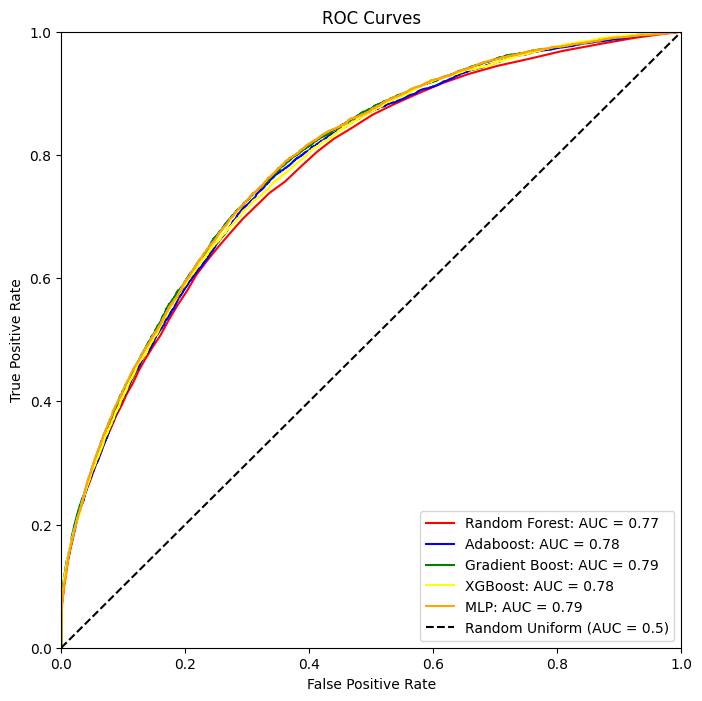

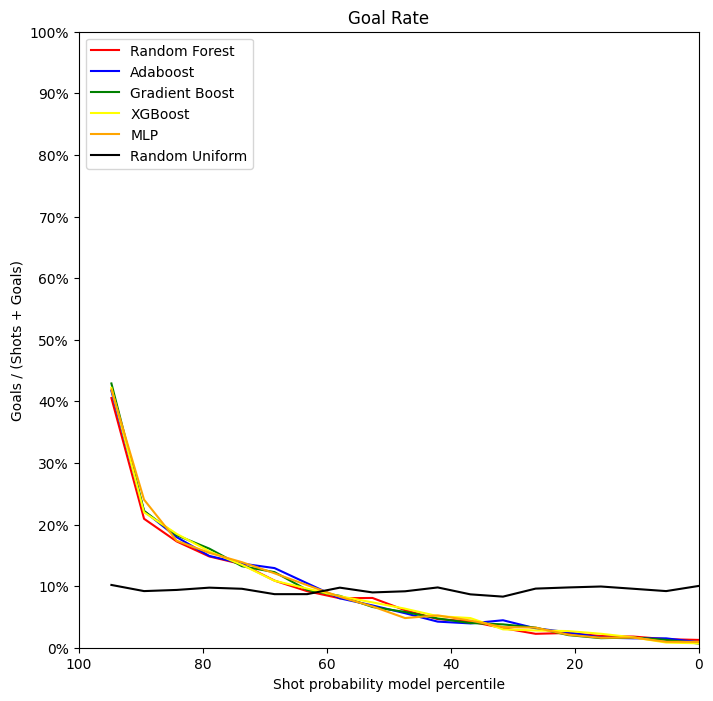

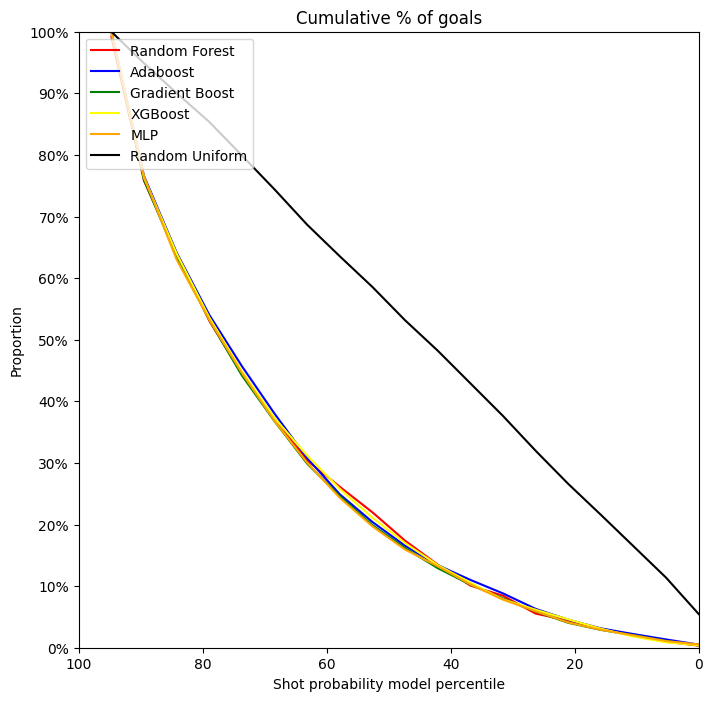

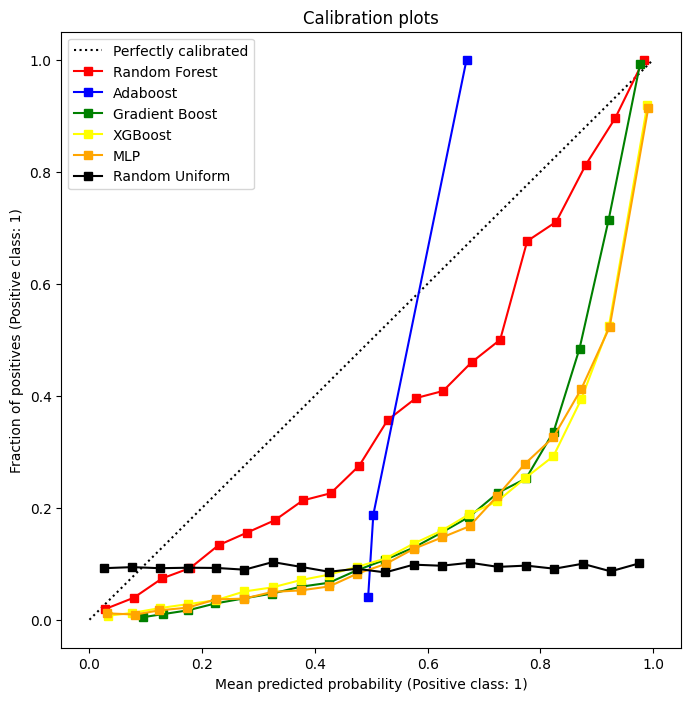

In [87]:
classifiers = [(random_search_forest, 'Random Forest', X_valid, y_valid),
               (random_search_balanced_forest, 'Balanced Random Forest', X_valid, y_valid),
               (random_search_adaboost, 'Adaboost', X_valid, y_valid),
               (random_search_gradientboost, 'Gradient Boost', X_valid, y_valid),
               (random_search_xgboost, 'XGBoost', X_valid, y_valid),
               (pipeline_mlp, 'MLP', X_valid, y_valid)]


VizManager.plot_all_figures(classifiers, add_random=True)

In [ ]:
# Test without resampling
clf_adaboost = AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)
pipeline_adaboost = Pipeline(steps= [('s', scaler), ('m', clf_adaboost)])
pipeline_adaboost.fit(X_train, y_train)
y_pred = pipeline_adaboost.predict(X_valid)
print(classification_report(y_valid, y_pred))